In [1]:
import matplotlib.pyplot as plt

In [2]:
from visuals import *


# Test trajectories

In [80]:
w = 2*np.pi/5

In [81]:
t_test = np.linspace(0,20,2000)

In [82]:
x_acc_test = - np.sin(w*t_test)

In [83]:
fig = go.Figure()
fig.add_scatter(x = t_test, y = x_acc_test, mode='lines', name='Sum squares')
fig.show()

In [92]:
track1_test, basis1_test = phase_track(x_acc_test.reshape([-1,1]), 500, 2)

Explained variation for 2 principal components: [0.50000315 0.49999685]
Cumulative explained variationfor 2 principal components: 1.0000000000000002



In [93]:
plot_phase_track(track1_test)

In [94]:
track2_test, basis2_test = phase_track(x_acc_test.reshape([-1,1]), 200, 3)

Explained variation for 3 principal components: [6.32462871e-01 3.67537129e-01 3.55915346e-32]
Cumulative explained variationfor 3 principal components: 1.0



In [95]:
plot_phase_track(track2_test)

# Real data

In [10]:
data = pd.read_csv('walk_30sec_5m_all_acc.csv', delimiter =';', decimal=',')

In [14]:
data.head()

,time,X_value,Y_value,Z_value
0,0.0039,-3.49085,1.50839,9.34725
1,0.0048,-3.38550,1.49882,9.54358
2,0.0062,-3.28255,1.48924,9.72554
3,0.0081,-3.23467,1.48924,9.81174
4,0.0105,-3.15565,1.48924,9.98413


In [52]:
x_acc = (data['Y_value'].values).astype(float).reshape([-1,])[4000:-4000]
t = (data['time'].values).astype(float).reshape([-1,])[4000:-4000]
t = t - t[0]
x_acc, t

(array([-11.38717, -11.73674, -11.89955, ...,  -5.64809,  -5.78457,
         -5.84203]),
 array([0.00000e+00, 1.30000e-03, 2.90000e-03, ..., 1.75211e+01,
        1.75233e+01, 1.75246e+01]))

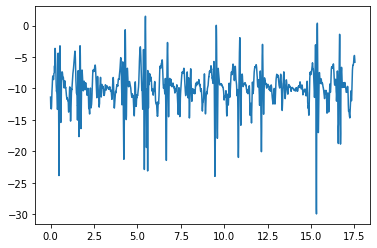

In [53]:
plt.plot(t,x_acc)

In [54]:
fig = go.Figure()
fig.add_scatter(x = t, y = x_acc, mode='lines', name='Sum squares')
fig.show()

In [55]:
track1, basis1 = phase_track(x_acc.reshape([-1,1]), 200, 2)

Explained variation for 2 principal components: [0.16336821 0.15163412]
Cumulative explained variationfor 2 principal components: 0.31500233039962244



In [56]:
plot_phase_track(track1)

In [57]:
track2, basis2 = phase_track(x_acc.reshape([-1,1]), 200, 3)

Explained variation for 3 principal components: [0.16336821 0.15163412 0.14337722]
Cumulative explained variationfor 3 principal components: 0.45837955517422513



In [58]:
plot_phase_track(track2)